In [1]:
import pandas as pd

df = pd.read_csv("reddit_mental_health_clean.csv")

df.head()

,post,label
0,Gf seems to have depression and I don't know w...,Depression
1,"Whats my purpose in life? Hello everyone, (sor...",Depression
2,Happy days are few and far between I have alwa...,Depression
3,Fuck this life I’ve never done a r/depression ...,Depression
4,Anyone else feel like they project the kind of...,Depression


In [2]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["label"])

print(label_encoder.classes_)

['Anxiety' 'BPD' 'Control' 'Depression' 'SuicideWatch']


In [3]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label_id"],
    random_state=42
)

print(len(train_df), len(test_df))

29192 7298


In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
import torch
from torch.utils.data import Dataset

class RedditDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [6]:
from torch.utils.data import DataLoader

train_dataset = RedditDataset(
    train_df["post"].tolist(),
    train_df["label_id"].tolist(),
    tokenizer
)

test_dataset = RedditDataset(
    test_df["post"].tolist(),
    test_df["label_id"].tolist(),
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [7]:
from transformers import BertForSequenceClassification

num_labels = len(label_encoder.classes_)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded on:", device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded on: cuda


In [8]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [9]:
from tqdm import tqdm

epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} Average Loss: {avg_loss}")

Epoch 1: 100%|██████████| 1825/1825 [23:27<00:00,  1.30it/s, loss=0.339]



Epoch 1 Average Loss: 0.6108061624961356


Epoch 2: 100%|██████████| 1825/1825 [23:31<00:00,  1.29it/s, loss=0.898]



Epoch 2 Average Loss: 0.4149009115279537


Epoch 3: 100%|██████████| 1825/1825 [23:31<00:00,  1.29it/s, loss=0.103]


Epoch 3 Average Loss: 0.28818458287275


In [19]:
from sklearn.metrics import classification_report

model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

     Anxiety       0.86      0.86      0.86      1460
         BPD       0.83      0.82      0.82      1459
     Control       0.97      0.98      0.97      1460
  Depression       0.67      0.61      0.64      1460
SuicideWatch       0.72      0.79      0.75      1459

    accuracy                           0.81      7298
   macro avg       0.81      0.81      0.81      7298
weighted avg       0.81      0.81      0.81      7298



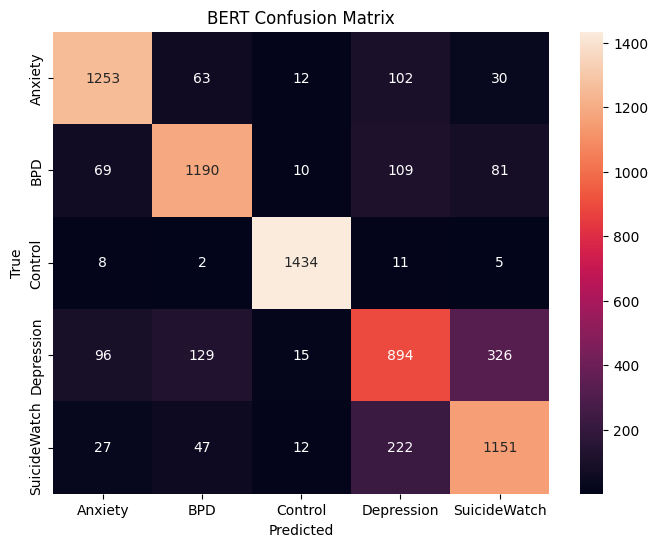

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_bert = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8,6))
sns.heatmap(cm_bert, annot=True, fmt="d",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BERT Confusion Matrix")
plt.show()